In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

from models.cnep import CNEP
from models.cnmp import CNMP
from data.data_generators import *

torch.set_float32_matmul_precision('high')

def get_free_gpu():
    gpu_util = []
    for i in range(torch.cuda.device_count()):
        torch.cuda.set_device(i)  # Switch GPU
#        gpu_util.append((i, torch.cuda.memory_stats()['reserved_bytes.all.current'] / (1024 ** 2)))
        gpu_util.append((i, torch.cuda.utilization()))
    gpu_util.sort(key=lambda x: x[1])
    return gpu_util[0][0]

if torch.cuda.is_available():
    available_gpu = get_free_gpu()
    if available_gpu == 0:
        device = torch.device("cuda:0")
    else:
        device = torch.device(f"cuda:{available_gpu}")
else:
    device = torch.device("cpu")

print("Device :", device)

Device : cuda:0


In [2]:
# Hyperparameters
batch_size = 32
n_max, m_max = 8, 8

t_steps = 200
num_demos = 128
num_classes = 4
num_indiv = num_demos//num_classes  # number of demos per class
dx, dy = 1, 1

num_val = 32
num_val_indiv = num_val//num_classes

colors = [sns.color_palette('tab10')[0], sns.color_palette('tab10')[1], sns.color_palette('tab10')[2], sns.color_palette('tab10')[3]]
sns.set_palette('tab10')

X: torch.Size([128, 200, 1]) Y: torch.Size([128, 200, 1]) VX: torch.Size([32, 200, 1]) VY: torch.Size([32, 200, 1])


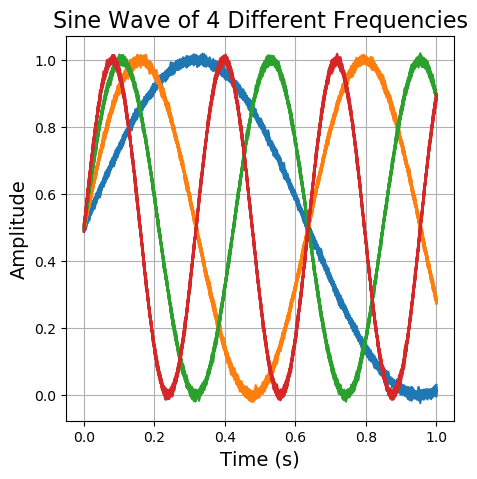

In [3]:
x = torch.linspace(0, 1, 200).repeat(num_indiv, 1)
y = torch.zeros(num_demos, t_steps, dy)

vx = torch.linspace(0, 1, 200).repeat(num_val_indiv, 1)
vy = torch.zeros(num_val, t_steps, dy)

for i in range(num_classes):
    start_ind = i*num_indiv
    coeff = (i+1)/2*torch.pi
    noise = torch.clamp(torch.randn((num_indiv, t_steps))*0.015, min=-.5, max=.5)
    y[start_ind:start_ind+num_indiv] = (torch.unsqueeze(generate_sin(x*coeff)+noise, -1)+1)/2.0

    noise = torch.unsqueeze(torch.clamp(torch.randn(vx.shape)*0.01, min=0), -1)
    start_ind = i*num_val_indiv
    vy[start_ind:start_ind+num_val_indiv] = y[start_ind:start_ind+num_val_indiv].clone() + noise

x = torch.unsqueeze(x.repeat(num_classes, 1), 2)  # since dx = 1
vx = torch.unsqueeze(vx.repeat(num_classes, 1), 2)
print("X:", x.shape, "Y:", y.shape, "VX:", vx.shape, "VY:", vy.shape)

plt.figure(figsize=(5, 5))
for i in range(num_demos):
    plt.plot(x[i, :, 0].cpu(), y[i, :, 0].cpu(), color=colors[i//num_indiv])
    # plt.plot(vx[i, :, 0].cpu(), vy[i, :, 0].cpu(), 'k', alpha=0.5)

# plt.legend(loc='lower left', fontsize=14)
plt.grid(True)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.title(f'Sine Wave of 4 Different Frequencies', fontsize=16)

x, y = x.to(device), y.to(device)

In [4]:
obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
tar_x = torch.zeros((batch_size, m_max, dx), dtype=torch.float32, device=device)
tar_y = torch.zeros((batch_size, m_max, dy), dtype=torch.float32, device=device)
obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)
tar_mask = torch.zeros((batch_size, m_max), dtype=torch.bool, device=device)

def prepare_masked_batch(t: list, traj_ids: list):
    obs.fill_(0)
    tar_x.fill_(0)
    tar_y.fill_(0)
    obs_mask.fill_(False)
    tar_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()
        m = torch.randint(1, m_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = permuted_ids[n:n+m]
        
        obs[i, :n, :dx] = traj[n_ids]
        obs[i, :n, dx:] = (n_ids/t_steps).unsqueeze(1)
        obs_mask[i, :n] = True
        
        tar_x[i, :m] = traj[m_ids]
        tar_y[i, :m] = (m_ids/t_steps).unsqueeze(1)
        tar_mask[i, :m] = True

val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

def prepare_masked_val_batch(t: list, traj_ids: list):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)
    val_obs_mask.fill_(False)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]

        n = torch.randint(1, n_max, (1,)).item()

        permuted_ids = torch.randperm(t_steps)
        n_ids = permuted_ids[:n]
        m_ids = torch.arange(t_steps)
        
        val_obs[i, :n, :dx] = traj[n_ids]
        val_obs[i, :n, dx:] = (n_ids/t_steps).unsqueeze(1)
        val_obs_mask[i, :n] = True
        
        val_tar_x[i] = traj[m_ids]
        val_tar_y[i] = (m_ids/t_steps).unsqueeze(1)

In [5]:
cnep_ = CNEP(1, 1, n_max, m_max, [64,64], num_decoders=4, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)
optimizer_cnep = torch.optim.Adam(lr=1e-4, params=cnep_.parameters())

# CNP(input_dim=1, hidden_dim=204, output_dim=1, n_max_obs=6, n_max_tar=6, num_layers=3, batch_size=batch_size).to(device)
cnmp_ = CNMP(1, 1, n_max, m_max, [104,104], decoder_hidden_dims=[104,104], batch_size=batch_size, device=device)
optimizer_cnmp = torch.optim.Adam(lr=1e-4, params=cnmp_.parameters())

def get_parameter_count(model):
    total_num = 0
    for param in model.parameters():
        total_num += param.shape.numel()
    return total_num

print("cnep:", get_parameter_count(cnep_), 'cnmp:', get_parameter_count(cnmp_))

if torch.__version__ >= "2.0":
    cnep, cnmp = torch.compile(cnep_), torch.compile(cnmp_)
else:
    cnep, cnmp = cnep_, cnmp_

cnep: 22028 cnmp: 22466


In [6]:
import time
import os

timestamp = int(time.time())
root_folder = f'outputs/sine/4_sine/cnmp_cnep/{str(timestamp)}/'

if not os.path.exists(root_folder):
    os.makedirs(root_folder)

if not os.path.exists(f'{root_folder}saved_models/'):
    os.makedirs(f'{root_folder}saved_models/')

if not os.path.exists(f'{root_folder}img/'):
    os.makedirs(f'{root_folder}img/')

torch.save(y, f'{root_folder}y.pt')


epochs = 1_000_000
epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
avg_loss_cnmp, avg_loss_cnep = 0, 0

val_per_epoch = 1000
min_vl_cnmp, min_vl_cnep = 1000000, 1000000

mse_loss = torch.nn.MSELoss()

tl_cnmp, tl_cnep = [], []
ve_cnmp, ve_cnep = [], []

cnmp_tl_path, cnep_tl_path = f'{root_folder}cnmp_training_loss.pt', f'{root_folder}cnep_training_loss.pt'
cnmp_ve_path, cnep_ve_path = f'{root_folder}cnmp_validation_error.pt', f'{root_folder}cnep_validation_error.pt'

for epoch in range(epochs):
    epoch_loss_cnmp, epoch_loss_cnep = 0, 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        prepare_masked_batch(x, traj_ids[i])

        optimizer_cnmp.zero_grad()
        pred = cnmp(obs, tar_x, obs_mask)
        loss = cnmp.loss(pred, tar_y, tar_mask)
        loss.backward()
        optimizer_cnmp.step()

        epoch_loss_cnmp += loss.item()

        optimizer_cnep.zero_grad()
        pred, gate = cnep(obs, tar_x, obs_mask)
        loss, nll = cnep.loss(pred, gate, tar_y, tar_mask)
        loss.backward()
        optimizer_cnep.step()

        epoch_loss_cnep += nll.item()

    epoch_loss_cnmp = epoch_loss_cnmp/epoch_iter
    tl_cnmp.append(epoch_loss_cnmp)
    epoch_loss_cnep = epoch_loss_cnep/epoch_iter
    tl_cnep.append(epoch_loss_cnep)

    if epoch % val_per_epoch == 0:
        with torch.no_grad():
            v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
            val_err_cnmp, val_err_cnep = 0, 0

            for j in range(v_epoch_iter):
                prepare_masked_val_batch(vx, v_traj_ids[j])

                p = cnmp.val(val_obs, val_tar_x, val_obs_mask)
                vp_means = p[:, :, :dy]
                val_err_cnmp += mse_loss(vp_means, val_tar_y).item()

                p, g = cnep.val(val_obs, val_tar_x, val_obs_mask)
                dec_id = torch.argmax(g.squeeze(1), dim=-1)
                vp_means = p[dec_id, torch.arange(batch_size), :, :dy]
                val_err_cnep += mse_loss(vp_means, val_tar_y).item()

            val_err_cnmp = val_err_cnmp/v_epoch_iter
            val_err_cnep = val_err_cnep/v_epoch_iter

            if val_err_cnmp < min_vl_cnmp:
                min_vl_cnmp = val_err_cnmp
                print(f'CNMP New best: {min_vl_cnmp}')
                torch.save(cnmp.state_dict(), f'{root_folder}saved_models/cnmp.pt')

            if val_err_cnep < min_vl_cnep:
                min_vl_cnep = val_err_cnep
                print(f'CNEP New best: {min_vl_cnep}')
                torch.save(cnep.state_dict(), f'{root_folder}saved_models/cnep.pt')

            ve_cnmp.append(val_err_cnmp)
            ve_cnep.append(val_err_cnep)

    avg_loss_cnmp += epoch_loss_cnmp
    avg_loss_cnep += epoch_loss_cnep

    if epoch % val_per_epoch == 0:
        print("Epoch: {}, Loss: {}, {}, Min Err: {}, {}".format(epoch, avg_loss_cnmp/val_per_epoch, avg_loss_cnep/val_per_epoch, min_vl_cnmp, min_vl_cnep))
        avg_loss_cnmp, avg_loss_cnep = 0, 0

torch.save(torch.Tensor(tl_cnmp), cnmp_tl_path)
torch.save(torch.Tensor(ve_cnmp), cnmp_ve_path)

CNMP New best: 0.16846339404582977
CNEP New best: 0.39916208386421204
Epoch: 0, Loss: 0.0007649352848529816, 0.0005913103818893432, Min Err: 0.16846339404582977, 0.39916208386421204
CNMP New best: 1.042220992530929e-05
CNEP New best: 1.0452544074723846e-07
Epoch: 1000, Loss: -3.746397603022633, -4.393733529845252, Min Err: 1.042220992530929e-05, 1.0452544074723846e-07
CNMP New best: 6.156049607852765e-07
CNEP New best: 8.633769965626925e-08
Epoch: 2000, Loss: -8.671350472762017, -10.318730044046417, Min Err: 6.156049607852765e-07, 8.633769965626925e-08
CNMP New best: 2.666829423958461e-08
CNEP New best: 3.9248774896805116e-08
Epoch: 3000, Loss: -13.683805535564897, -16.37565761113353, Min Err: 2.666829423958461e-08, 3.9248774896805116e-08
Epoch: 4000, Loss: -18.734242669027996, -22.446074683478102, Min Err: 2.666829423958461e-08, 3.9248774896805116e-08
CNMP New best: 1.531086013528693e-08
Epoch: 5000, Loss: -23.843784354553325, -28.519359826687722, Min Err: 1.531086013528693e-08, 3.924